# Imports 

In [194]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import torch
from sympy.matrices.benchmarks.bench_matrix import timeit_Matrix__getitem_ii
from torch import nn, optim
from torch.onnx.symbolic_opset9 import logit
from torch.utils.data import Dataset, DataLoader 

from torchvision import transforms as T

import timm

![](Untitled-design.png)

# Configurations

In [195]:
TRAIN_CSV = 'train.csv'
VALID_CSV = 'valid.csv'

BATCH_SIZE = 128
DEVICE = 'cpu'

MODEL_NAME = 'efficientnet_b0'

LR = 0.001
EPOCHS = 15

In [196]:
df_train = pd.read_csv(TRAIN_CSV)
df_valid = pd.read_csv(VALID_CSV)

In [197]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,8183,8184,8185,8186,8187,8188,8189,8190,8191,labels
0,0.631373,0.623529,0.713726,0.705882,0.658824,0.666667,0.654902,0.635294,0.647059,0.705882,...,0.611765,0.650980,0.658824,0.600000,0.603922,0.654902,0.694118,0.658824,0.666667,Squiggle
1,0.725490,0.752941,0.749020,0.701961,0.690196,0.721569,0.709804,0.745098,0.654902,0.721569,...,0.698039,0.721569,0.686275,0.713726,0.682353,0.690196,0.698039,0.701961,0.725490,Squiggle
2,0.717647,0.701961,0.713726,0.733333,0.705882,0.717647,0.725490,0.682353,0.717647,0.674510,...,0.694118,0.705882,0.682353,0.639216,0.713726,0.670588,0.678431,0.737255,0.674510,Squiggle
3,0.705882,0.674510,0.654902,0.678431,0.666667,0.662745,0.678431,0.662745,0.686275,0.686275,...,0.662745,0.631373,0.643137,0.705882,0.662745,0.705882,0.666667,0.654902,0.631373,Squiggle
4,0.647059,0.729412,0.701961,0.674510,0.611765,0.698039,0.713726,0.662745,0.701961,0.674510,...,0.670588,0.705882,0.674510,0.721569,0.694118,0.674510,0.705882,0.749020,0.729412,Squiggle


In [198]:
print(f"No. of examples present in df_train : {len(df_train)}")
print(f"No. of examples present in df_valid : {len(df_valid)}")
print(f"Labels are : {df_train['labels'].unique()}")

No. of examples present in df_train : 3200
No. of examples present in df_valid : 800
Labels are : ['Squiggle' 'Narrowbanddrd' 'Noises' 'Narrowband']


Text(0.5, 1.0, 'Squiggle')

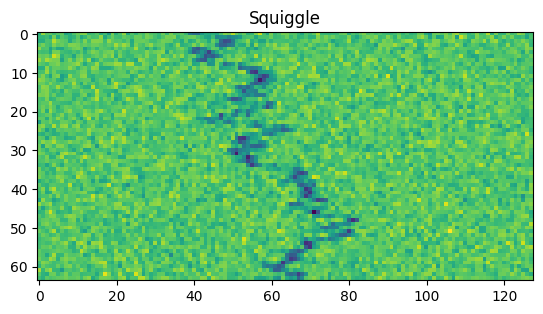

In [199]:
idx = 700
row = df_train.iloc[idx]
image_pixels = np.array(row[0:8192], dtype=np.float64)
label = row.labels

image = np.resize(image_pixels, (64, 128))  # 64 * 128 = 8192

plt.imshow(image)
plt.title(label)


# Declare Spec Augmentations 

![](image6.png)

In [200]:
from spec_augment import TimeMask, FreqMask

In [201]:
def get_train_transform():
    return T.Compose([
        TimeMask(T = 15, num_masks= 4),
        FreqMask(F = 15, num_masks= 3),
    ])

# Create Custom Dataset 

In [202]:
class SpecDataset(Dataset):
    def __init__(self, df, augmentations=None):
        self.df = df
        self.augmentations = augmentations
        
        label_mapper = {
            'Squiggle': int(0),
            'Narrowband': 1,
            'Narrowbanddrd': 2,
            'Noises': 3,
        }

        
        self.df.labels = self.df.labels.map(label_mapper)
        
        

    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_pixels = np.array(row[0:8192], dtype=np.float64)
        
        image = np.resize(image_pixels, (64, 128, 1))  # (height, width, channel)
        label = np.array(row.labels, dtype=np.float64)
        
        image = torch.Tensor(image).permute(2, 0, 1)  # (channel, height, width): pytorch convention
        
        if self.augmentations is not None:
            image = self.augmentations(image)
        
        return image.float(), label


In [203]:
trainset = SpecDataset(df_train, augmentations=get_train_transform())
validset = SpecDataset(df_valid)



0.0


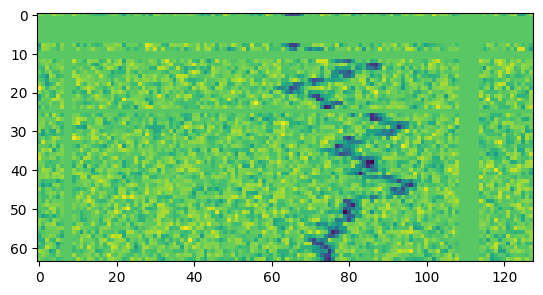

In [204]:
image, label = trainset[591]

plt.imshow(image.permute(0, 1, 2).squeeze())
print(label)

# Load dataset into Batches

In [205]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [206]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 25
Total no. of batches in validloader : 7


In [207]:
for images, labels in trainloader:
    break;

print(f"One image batch shape : {images.shape}")
print(f"One label batch shape : {labels.shape}")

One image batch shape : torch.Size([128, 1, 64, 128])
One label batch shape : torch.Size([128])


# Load Model

In [208]:
class SpecModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.net = timm.create_model(MODEL_NAME, num_classes=4, pretrained=True, in_chans = 1)
    
    def forward(self, images, labels = None):
        logits = self.net(images)
        
        if labels is not None:
            loss = nn.CrossEntropyLoss()
            return logits, loss(logits, labels)
        return logits
        

In [209]:
model = SpecModel()
model

SpecModel(
  (net): EfficientNet(
    (conv_stem): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(3

# Create Train and Eval Function

In [210]:
from tqdm.notebook import tqdm 
from utils import multiclass_accuracy

In [211]:
def train_fn(model, dataloader, optimizer, current_epoch):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    progress_bar = tqdm(dataloader, desc="EPOCH" + "[TRAIN]" + str(current_epoch + 1) + "/" + str(EPOCHS))
    
    for t, data in enumerate(progress_bar):
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        logits, loss = model(images, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_acc += multiclass_accuracy(logits, labels)
        
        temp = {
            'loss': '%6f' % float(total_loss / (t+1)),
            'acc': '%6f' % float(total_acc / (t+1)),
        }
        progress_bar.postfix(temp)
        
    return total_loss / len(dataloader), total_acc / len(dataloader)


In [212]:
def eval_fn(model, dataloader, current_epoch):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    progress_bar = tqdm(dataloader, desc="EPOCH" + "[VALID]" + str(current_epoch + 1) + "/" + str(EPOCHS))
    
    with torch.no_grad():
        for t, data in enumerate(progress_bar):
            images, labels = data
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            logits, loss = model(images, labels)
            
            total_loss += loss.item()
            total_acc += multiclass_accuracy(logits, labels)
            
            temp = {
                'loss': '%6f' % float(total_loss / (t+1)),
                'acc': '%6f' % float(total_acc / (t+1)),
            }
            progress_bar.set_postfix(temp)
            
        return total_loss / len(dataloader), total_acc / len(dataloader)

# Training Loop 

In [213]:
def fit(model, trainloader, validloader, optimizer):
    best_valid_loss = np.inf
    
    for i in range(EPOCHS):
        train_loss, train_acc = train_fn(model, trainloader, optimizer, i)
        valid_loss, valid_acc = eval_fn(model, validloader, i)
        
        if valid_loss < best_valid_loss:
            torch.save(model.state_dict(), MODEL_NAME + '-best.weights.pt')
            print('SAVED-BEST-WEIGHTS')
            best_valid_loss = valid_loss
    

In [214]:
optimizer = optim.AdamW(model.parameters(), lr=LR)
fit(model, trainloader, validloader, optimizer)

EPOCH[TRAIN]1/15:   0%|          | 0/25 [00:00<?, ?it/s]

RuntimeError: expected scalar type Long but found Double

# Inference 

In [4]:
from utils import view_classify